To create the dataset used in this notebook (see `radburst/detection/morph_ops/create_dataframe.py`), all data samples were initially processed to try to detect candidate bounding boxes for bursts.
- When a bounding box(s) are found they are filtered and we create a dataset entry from the properties (features) of that box.
- When no bounding boxes are found, we add an entry of zeros for every feature.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pkg_resources

# Define the path to the CSV file as a resource
csv_file_path = pkg_resources.resource_filename('radburst', 'detection/morph_ops/bbox_data.csv')

df = pd.read_csv(csv_file_path)
df.head()

,height,width,area,max_row,min_row,mean,median,hw_ratio,burst
0,15,63,945,151,136,0.606935,0.356777,0.238095,0
1,22,92,2024,187,165,0.635232,0.281474,0.239130,0
2,23,74,1702,187,164,0.597776,0.381986,0.310811,0
3,33,47,1551,187,154,0.500389,0.000000,0.702128,0
4,21,56,1176,176,155,0.545951,0.000000,0.375000,0


In [21]:
# Split the data into features and target
X = df.drop('burst', axis=1)
y = df['burst']

model = GradientBoostingClassifier(random_state=10,
                                  n_estimators=200,
                                  learning_rate=.1)
num_folds = 3

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
precision_scores = []
recall_scores = []
f1_scores = []

feature_importances = []
confusion_matrices = [] 
auroc_scores = [] 
fpr_tpr_thresholds = []
optimal_thresholds = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit model and get probabilities
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Predict probabilities for AUROC
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)  # Get FPR, TPR for ROC curve
    auroc_scores.append(roc_auc_score(y_test, y_prob))  # Store AUROC score
    fpr_tpr_thresholds.append((fpr, tpr, thresholds))
    
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    feature_importances.append(model.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)
    

# Cross-Validation scores and averages
print(f"{num_folds}-FOLD CROSS-VALIDATION (CV)")
print("CV Precision Scores:", [round(score, 3) for score in precision_scores])
print("CV Recall Scores:", [round(score, 3) for score in recall_scores])
print("CV F1 Scores:", [round(score, 3) for score in f1_scores])

print("optimal thresholds:", optimal_thresholds)

print("\nCV Average Precision:", round(sum(precision_scores) / len(precision_scores), 3))
print("CV Average Recall:", round(sum(recall_scores) / len(recall_scores), 3))
print("CV Average F1 Score:", round(sum(f1_scores) / len(f1_scores), 3))

3-FOLD CROSS-VALIDATION (CV)
CV Precision Scores: [0.833, 0.864, 0.818]
CV Recall Scores: [0.714, 0.704, 0.643]
CV F1 Scores: [0.769, 0.776, 0.72]
optimal thresholds: []

CV Average Precision: 0.838
CV Average Recall: 0.687
CV Average F1 Score: 0.755


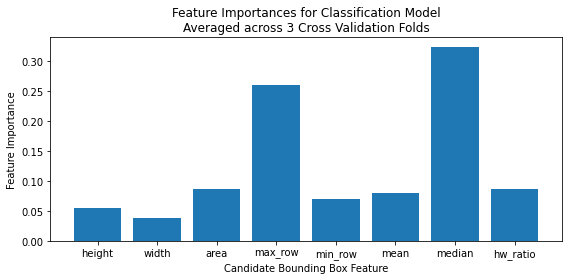

In [4]:
# Feature importances

avg_feature_importances = np.mean(feature_importances, axis=0)

plt.figure(figsize=(8,4))
plt.bar(X.columns, avg_feature_importances)
plt.xlabel('Candidate Bounding Box Feature')
plt.ylabel('Feature Importance')
plt.title(f'Feature Importances for Classification Model\nAveraged across {num_folds} Cross Validation Folds')
plt.tight_layout()
plt.show()

Because all feature values were set to 0 for inputs with no candidates, the feature importances might be misleading. The plot above could be reflecting a strong correlation between median = 0 and non-burst samples. This is not necessarily a problem but it means that 'median' could be placeholder for 'no bounding box detected'.

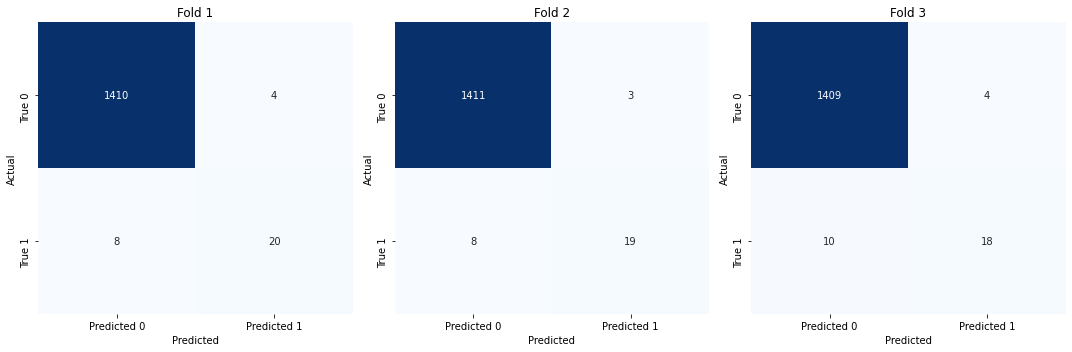

In [5]:
# Confusion matrix plots for each fold in CV

fig, axes = plt.subplots(1, num_folds, figsize=(15, 5))

for i, cm in enumerate(confusion_matrices):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    axes[i].set_title(f'Fold {i+1}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Adjust layout
plt.tight_layout()
plt.show()

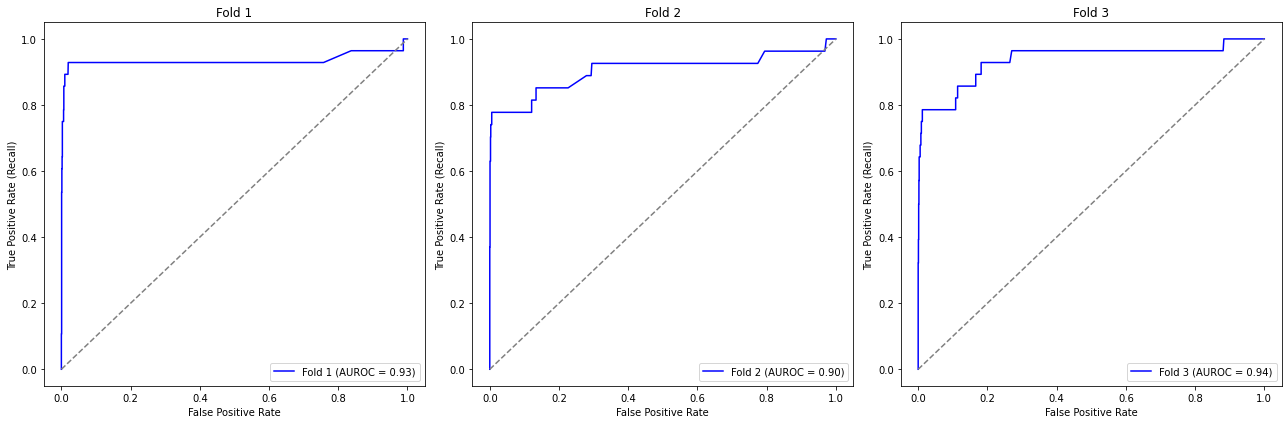

Average AUROC: 0.925


In [6]:
# AUROC plots for each fold in CV

fig, axes = plt.subplots(1, num_folds, figsize=(18, 6))

for i, (fpr, tpr, thresholds) in enumerate(fpr_tpr_thresholds):
    ax = axes[i]
    ax.plot(fpr, tpr, color='b', label=f'Fold {i+1} (AUROC = {auroc_scores[i]:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
    ax.set_title(f'Fold {i+1}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate (Recall)')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"Average AUROC: {np.mean(auroc_scores):.3f}")

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    f1_score, precision_score, recall_score, 
    confusion_matrix, roc_auc_score, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Hyperparameter Grid
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__min_samples_split': [50, 100, 200],
    'classifier__min_samples_leaf': [5, 10, 15, 20, 30],
    'classifier__subsample': [0.6, 0.7, 0.8],
    'classifier__max_features': ['sqrt', 'log2', None]
}

# Create pipeline
def create_gb_pipeline(random_state=42):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', GradientBoostingClassifier(
            random_state=random_state
        ))
    ])

# Advanced Cross-Validation
def advanced_cv_evaluation(X, y, num_folds=3, random_state=42):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    
    # Randomized Search Cross-Validation
    rs_cv = RandomizedSearchCV(
        estimator=create_gb_pipeline(),
        param_distributions=param_dist,
        n_iter=20,  # Number of parameter settings sampled
        cv=skf,
        scoring='f1',
        n_jobs=-1,
        random_state=random_state,
        verbose=2
    )
    
    # Fit the randomized search
    rs_cv.fit(X, y)
    
    # Best model details
    best_model = rs_cv.best_estimator_
    
    # Print best hyperparameters
    print("\nBest Hyperparameters:")
    for param, value in rs_cv.best_params_.items():
        print(f"{param}: {value}")
    
    print("\nBest Cross-Validation F1 Score:", rs_cv.best_score_)
    
    # Detailed Cross-Validation
    cv_results = {
        'precision': [], 
        'recall': [], 
        'f1': [], 
        'auroc': []
    }
    
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the best model
        best_model.fit(X_train, y_train)
        
        # Predictions
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        cv_results['precision'].append(precision_score(y_test, y_pred))
        cv_results['recall'].append(recall_score(y_test, y_pred))
        cv_results['f1'].append(f1_score(y_test, y_pred))
        cv_results['auroc'].append(roc_auc_score(y_test, y_prob))
    
    # Print detailed metrics
    print("\nDetailed Metrics:")
    for metric, values in cv_results.items():
        print(f"{metric.capitalize()}:")
        print(f"  Mean: {np.mean(values):.4f}")
        print(f"  Std Dev: {np.std(values):.4f}")
    
    # Feature Importance
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    feature_names = X.columns
    feature_importance_sorted = sorted(
        zip(feature_importance, feature_names), 
        reverse=True
    )
    
    print("\nTop 10 Most Important Features:")
    for importance, name in feature_importance_sorted[:10]:
        print(f"{name}: {importance:.4f}")
    
    return best_model, rs_cv.best_params_

# Assuming X and y are already defined
# X = df.drop('burst', axis=1)
# y = df['burst']

# Run advanced cross-validation
best_model, best_params = advanced_cv_evaluation(X, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Hyperparameters:
classifier__subsample: 0.7
classifier__n_estimators: 500
classifier__min_samples_split: 200
classifier__min_samples_leaf: 15
classifier__max_features: sqrt
classifier__max_depth: 3
classifier__learning_rate: 0.1

Best Cross-Validation F1 Score: 0.7758125472411187

Detailed Metrics:
Precision:
  Mean: 0.9198
  Std Dev: 0.0151
Recall:
  Mean: 0.6755
  Std Dev: 0.0744
F1:
  Mean: 0.7758
  Std Dev: 0.0462
Auroc:
  Mean: 0.9260
  Std Dev: 0.0131

Top 10 Most Important Features:
max_row: 0.4334
min_row: 0.1406
height: 0.1136
mean: 0.1083
area: 0.0681
hw_ratio: 0.0657
width: 0.0370
median: 0.0333
